In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm

# Configuration
IMG_SIZE = 128
BATCH_SIZE = 64
DATA_DIR = 'data'
TEST_DIR = os.path.join(DATA_DIR, 'test')
MODEL_PATH = 'asl_mobilenet_v2.pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")

Using device: cuda


In [9]:
# --- MobileNetV2 Architecture Definition ---
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.ReLU6(inplace=True)
        )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, width_mult=1.0):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        input_channel = int(input_channel * width_mult)
        self.last_channel = int(last_channel * width_mult) if width_mult > 1.0 else last_channel
        features = [ConvBNReLU(3, input_channel, stride=2)]
        
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
                
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1))
        
        self.features = nn.Sequential(*features)
        
        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        return x

In [10]:
class ASLDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        
        print(f"Scanning {root_dir}...")
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(cls_dir, img_name))
                    self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Read image
        img = cv2.imread(img_path)
        
        # Preprocessing: Grayscale + CLAHE
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        equalized = clahe.apply(gray)
        
        # Convert back to 3 channels for MobileNet compatibility
        img_processed = cv2.merge([equalized, equalized, equalized])
        
        # Resize
        img_processed = cv2.resize(img_processed, (IMG_SIZE, IMG_SIZE))
        
        # To Tensor
        img_tensor = transforms.ToTensor()(img_processed)
        
        if self.transform:
            img_tensor = self.transform(img_tensor)
            
        return img_tensor, label

In [11]:
# Load Test Data
test_dataset = ASLDataset(TEST_DIR)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

NUM_CLASSES = len(test_dataset.classes)
print(f"Test dataset size: {len(test_dataset)}")
print(f"Classes: {test_dataset.classes}")

# Load Model
model = MobileNetV2(num_classes=NUM_CLASSES)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print("Model loaded successfully.")
else:
    print(f"Error: Model file '{MODEL_PATH}' not found.")

model = model.to(DEVICE)
model.eval()

Scanning data\test...
Test dataset size: 2025
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing']


C:\Users\Admin\AppData\Local\Temp\ipykernel_16820\3489563184.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=D

Model loaded successfully.


MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [12]:
all_preds = []
all_labels = []

print("Evaluating...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate Metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy:.4f}")

class_names = test_dataset.classes
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Evaluating...


100%|██████████| 32/32 [00:28<00:00,  1.13it/s]


Test Accuracy: 0.9931

Classification Report:
              precision    recall  f1-score   support

           A       0.99      1.00      0.99        75
           B       1.00      0.99      0.99        75
           C       1.00      1.00      1.00        75
           D       0.99      1.00      0.99        75
           E       1.00      1.00      1.00        75
           F       1.00      1.00      1.00        75
           G       0.99      0.99      0.99        75
           H       0.97      0.97      0.97        75
           I       1.00      0.97      0.99        75
           J       1.00      1.00      1.00        75
           K       0.99      1.00      0.99        75
           L       1.00      1.00      1.00        75
           M       0.99      0.95      0.97        75
           N       0.97      0.99      0.98        75
           O       1.00      1.00      1.00        75
           P       1.00      1.00      1.00        75
           Q       1.00      1.00 

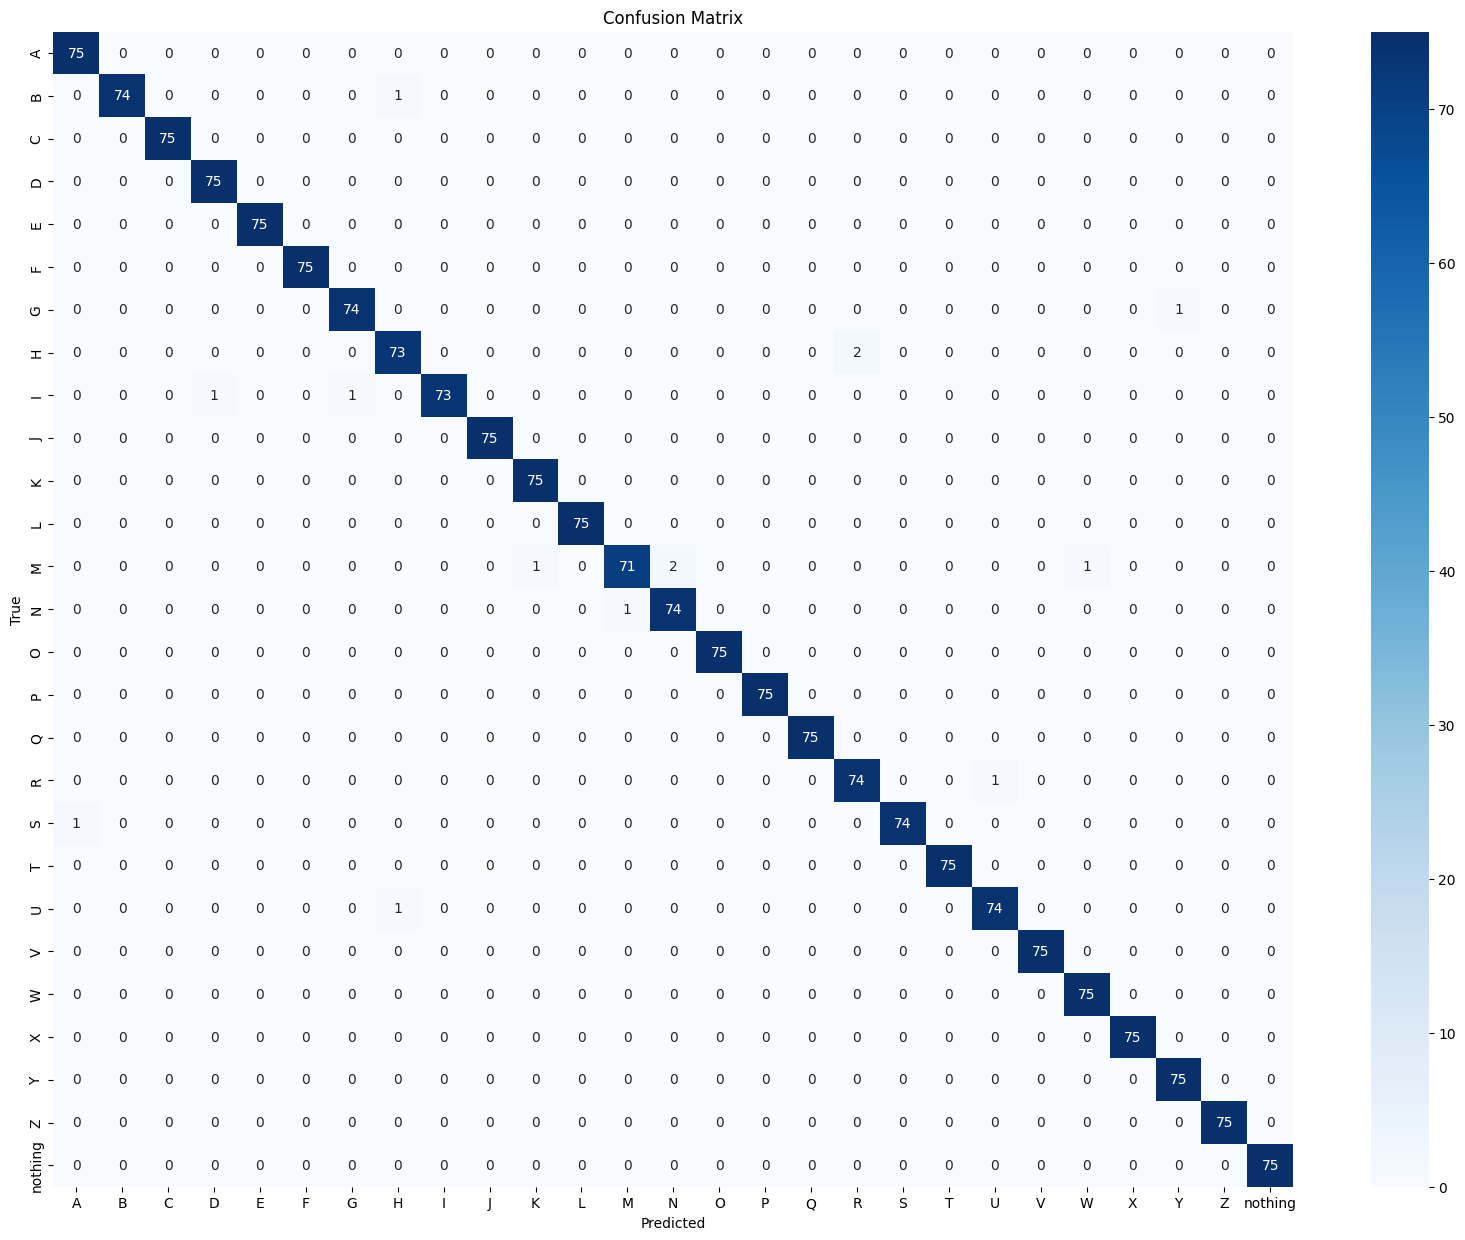

In [13]:
plt.figure(figsize=(20, 15))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

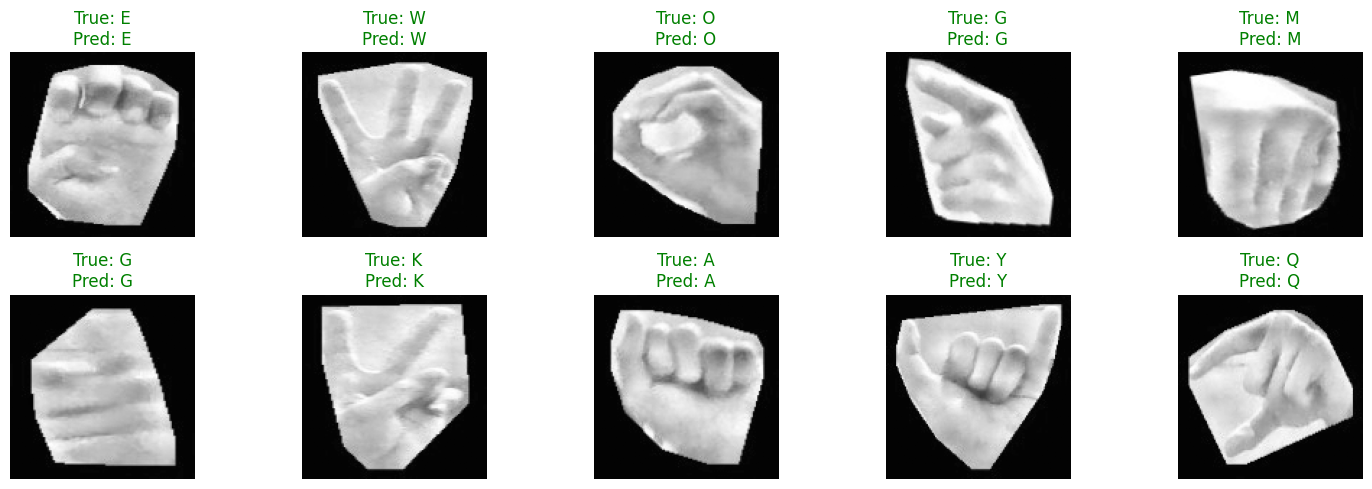

In [14]:
def show_predictions(dataset, model, num_images=10):
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            
        predicted_label = dataset.classes[predicted.item()]
        true_label = dataset.classes[label]
        
        # Convert tensor back to image for display
        img_display = image.permute(1, 2, 0).numpy()
        
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(img_display, cmap='gray')
        plt.axis('off')
        
        color = 'green' if predicted_label == true_label else 'red'
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
    plt.tight_layout()
    plt.show()

show_predictions(test_dataset, model, num_images=10)